# Working with morphologies

In this tutorial, you will learn how to:

- Load morphologies and make them compatible with `Jaxley`  
- How to use the visualization features  
- How to assemble a small network of morphologically accurate cells.  

Here is a code snippet which you will learn to understand in this tutorial:
```python
import jaxley as jx

cell = jx.read_swc("my_cell.swc", nseg=4, assign_groups=True)
```

To work with more complicated morphologies, `Jaxley` supports importing morphological reconstructions via `.swc` files.
`.swc` is currently the only supported format. Other formats like `.asc` need to be converted to `.swc` first, for example using the BlueBrain's [morph-tool](https://github.com/BlueBrain/morph-tool). For more information on the exact specifications of `.swc` see [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).

In [73]:
import jaxley as jx
from jaxley.synapses import IonotropicSynapse
import matplotlib.pyplot as plt

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader. The reader traces the morphology and identifies all uninterrupted sections. These are then partitioned into branches, each of which will be approximated by a number of equally many compartments that can be simulated fully in parallel.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [85]:
# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = jx.read_swc(fname, nseg=8, max_branch_len=2000.0, assign_groups=True)

# print shape (num_cells, num_branches, num_comps)
print(cell.shape)

cell.show()

(1, 157, 8)


,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,0.01250,8.119,5000.0,1.0,-70.0
1,1,0,0,0.01250,8.119,5000.0,1.0,-70.0
2,2,0,0,0.01250,8.119,5000.0,1.0,-70.0
3,3,0,0,0.01250,8.119,5000.0,1.0,-70.0
4,4,0,0,0.01250,8.119,5000.0,1.0,-70.0
...,...,...,...,...,...,...,...,...
1251,1251,156,0,24.12382,0.550,5000.0,1.0,-70.0
1252,1252,156,0,24.12382,0.550,5000.0,1.0,-70.0
1253,1253,156,0,24.12382,0.550,5000.0,1.0,-70.0
1254,1254,156,0,24.12382,0.550,5000.0,1.0,-70.0


As we can see, this yields a morphology that is approximated by 1256 compartments. Depending on the amount of detail that you need, you can also change the number of compartments in each branch:

In [86]:
cell = jx.read_swc(fname, nseg=2, max_branch_len=2000.0, assign_groups=True)

# print shape (num_cells, num_branches, num_comps)
print(cell.shape)

cell.show()

(1, 157, 2)


,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,0.050000,8.119000,5000.0,1.0,-70.0
1,1,0,0,0.050000,8.119000,5000.0,1.0,-70.0
2,2,1,0,6.241557,7.493344,5000.0,1.0,-70.0
3,3,1,0,6.241557,4.273686,5000.0,1.0,-70.0
4,4,2,0,4.160500,7.960000,5000.0,1.0,-70.0
...,...,...,...,...,...,...,...,...
309,309,154,0,49.728572,0.400000,5000.0,1.0,-70.0
310,310,155,0,46.557908,0.494201,5000.0,1.0,-70.0
311,311,155,0,46.557908,0.302202,5000.0,1.0,-70.0
312,312,156,0,96.495281,0.742532,5000.0,1.0,-70.0


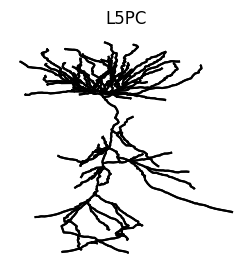

In [54]:
# visualize the cell
cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. This is stored in the `cell.xyzr` attribute in a per branch fashion.

To highlight each branch seperately, we can iterate over them.

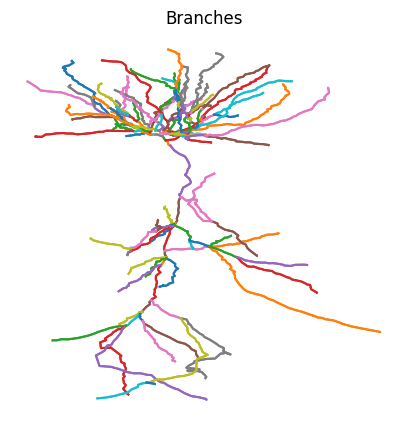

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i in range(cell.shape[1]):
    cell.branch(i).vis(ax=ax, col=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['soma', 'basal', 'apical', 'custom']


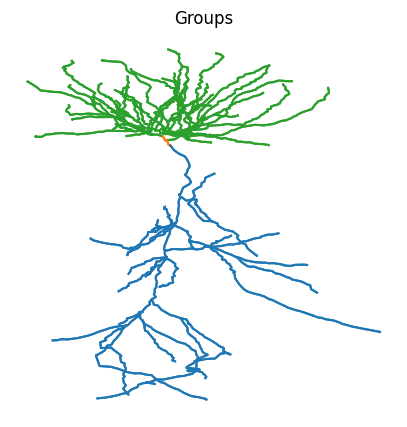

In [60]:
print(list(cell.group_nodes.keys()))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, col=colors[2])
cell.soma.vis(ax=ax, col=colors[1])
cell.apical.vis(ax=ax, col=colors[0])
plt.axis("off")
plt.title("Groups")
plt.show()

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To seperate out the cells, we therefore have to move them to a new location first.

/home/jnsbck/Uni/PhD/projects/jaxleyverse/jaxley/jaxley/modules/base.py:1528: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


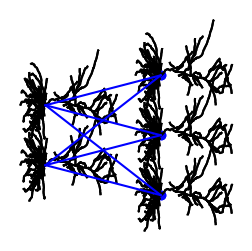

In [ ]:
net = jx.Network([cell]*5)
jx.connect(net[0,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[4,0,0], IonotropicSynapse())

jx.connect(net[1,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 300)
net.cell(1).move(0, 500)

net.cell(2).move(900, 200)
net.cell(3).move(900, 400)
net.cell(4).move(900, 600)

net.vis()
plt.axis("off")
plt.show()

Congrats! You have now learned how to vizualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutroial on [how to build a network](https://jaxleyverse.github.io/jaxley/latest/tutorial/02_small_network/).